In [1]:
import numpy as np
from preprocess import get_features, load_data, feature_scaling
from data_augmentation import augment_awgn_waveforms
from torchinfo import summary
import torch.nn as nn
import torch
import os
from torchvision import models
from torchvision import transforms
from einops import rearrange

In [2]:
os.environ["PL_TORCH_DISTRIBUTED_BACKEND"] = "gloo"

cfg = {'data_name' : 'RAVDESS',
       'dataset': 'dataset/Actor_*/*.wav',
       'npy_name': 'features+labels.npy',
       'sample_rate': 48000,
       'minibatch': 32,  # pick minibatch size (of 32... always)
       'num_epochs': 500,
       'device': 'cuda'
      }

# RAVDESS dataset emotions
# shift emotions left to be 0 indexed for PyTorch
emotions_dict = {
    '0': 'surprised',
    '1': 'neutral',
    '2': 'calm',
    '3': 'happy',
    '4': 'sad',
    '5': 'angry',
    '6': 'fearful',
    '7': 'disgust'
}

# Additional attributes from RAVDESS to play with
emotion_attributes = {
    '01': 'normal',
    '02': 'strong'
}

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def criterion(predictions, targets):
    return nn.CrossEntropyLoss()(input=predictions, target=targets)

In [4]:
def make_train_step(model, criterion, optimizer):

    # define the training step of the training phase
    def train_step(X, Y):

        # forward pass
        output_logits, output_softmax = model(X)
        predictions = torch.argmax(output_softmax, dim=1)
        accuracy = torch.sum(Y == predictions)/float(len(Y))

        # compute loss on logits because nn.CrossEntropyLoss implements log softmax
        loss = criterion(output_logits, Y)

        # compute gradients for the optimizer to use
        loss.backward()

        # update network parameters based on gradient stored (by calling loss.backward())
        optimizer.step()

        # zero out gradients for next pass
        # pytorch accumulates gradients from backwards passes (convenient for RNNs)
        optimizer.zero_grad()

        return loss.item(), accuracy*100
    return train_step


In [5]:
def make_validate_fnc(model, criterion):
    def validate(X, Y):

        # don't want to update any network parameters on validation passes: don't need gradient
        # wrap in torch.no_grad to save memory and compute in validation phase:
        with torch.no_grad():

            # set model to validation phase i.e. turn off dropout and batchnorm layers
            model.eval()
            
            # get the model's predictions on the validation set
            output_logits, output_softmax = model(X)
            predictions = torch.argmax(output_softmax, dim=1)

            # calculate the mean accuracy over the entire validation set
            accuracy = torch.sum(Y == predictions)/float(len(Y))

            # compute error from logits (nn.crossentropy implements softmax)
            loss = criterion(output_logits, Y)

        return loss.item(), accuracy*100, predictions
    return validate


In [6]:
def make_save_checkpoint():
    def save_checkpoint(optimizer, model, epoch, filename):
        checkpoint_dict = {
            'optimizer': optimizer.state_dict(),
            'model': model.state_dict(),
            'epoch': epoch
        }
        torch.save(checkpoint_dict, filename)
    return save_checkpoint


In [7]:
def load_checkpoint(optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    epoch = checkpoint_dict['epoch']
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    return epoch

In [8]:
class EarlyStopping:
    def __init__(self, patience=10):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.flag = True

    def __call__(self, val_loss):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score:
            self.counter += 1
            self.flag = False
            # print(f'\nEarlyStopping counter: {self.counter} out of {self.patience}')

            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.flag = True


In [9]:
# instantiate lists to hold scalar performance metrics to plot later
train_losses = []
valid_losses = []

In [10]:
def train_earlystop(optimizer, model, num_epochs, X_train, Y_train, X_valid, Y_valid, pkl_name):
    global device
    early_stopping = EarlyStopping(patience=100)

    # get training set size to calculate # iterations and minibatch indices
    train_size = X_train.shape[0]

    # instantiate the checkpoint save function
    save_checkpoint = make_save_checkpoint()

    # instantiate the training step function
    train_step = make_train_step(model, criterion, optimizer=optimizer)

    # instantiate the validation loop function
    validate = make_validate_fnc(model, criterion)

    for epoch in range(num_epochs):

        # set model to train phase
        model.train()

        # shuffle entire training set in each epoch to randomize minibatch order
        train_indices = np.random.permutation(train_size)

        # shuffle the training set for each epoch:
        X_train = X_train[train_indices, :, :, :]
        Y_train = Y_train[train_indices]

        # instantiate scalar values to keep track of progress after each epoch so we can stop training when appropriate
        epoch_acc = 0
        epoch_loss = 0
        num_iterations = int(train_size / cfg['minibatch'])

        # create a loop for each minibatch of 32 samples:
        for i in range(num_iterations):

            # we have to track and update minibatch position for the current minibatch
            # if we take a random batch position from a set, we almost certainly will skip some of the data in that set
            # track minibatch position based on iteration number:
            batch_start = i * cfg['minibatch']
            # ensure we don't go out of the bounds of our training set:
            batch_end = min(batch_start + cfg['minibatch'], train_size)
            # ensure we don't have an index error
            actual_batch_size = batch_end-batch_start

            # get training minibatch with all channnels and 2D feature dims
            X = X_train[batch_start:batch_end, :, :, :]
            # get training minibatch labels
            Y = Y_train[batch_start:batch_end]

            # instantiate training tensors
            X_tensor = torch.tensor(X, device=cfg['device']).float()
            Y_tensor = torch.tensor(Y, dtype=torch.long, device=cfg['device'])

            # Pass input tensors thru 1 training step (fwd+backwards pass)
            loss, acc = train_step(X_tensor, Y_tensor)

            # aggregate batch accuracy to measure progress of entire epoch
            epoch_acc += acc * actual_batch_size / train_size
            epoch_loss += loss * actual_batch_size / train_size

            # keep track of the iteration to see if the model's too slow
            print('\r'+f'Epoch {epoch}: iteration {i}/{num_iterations}', end='')

        # create tensors from validation set
        X_valid_tensor = torch.tensor(X_valid, device=cfg['device']).float()
        Y_valid_tensor = torch.tensor(
            Y_valid, dtype=torch.long, device=cfg['device'])

        # calculate validation metrics to keep track of progress; don't need predictions now
        valid_loss, valid_acc, _ = validate(X_valid_tensor, Y_valid_tensor)

        # accumulate scalar performance metrics at each epoch to track and plot later
        train_losses.append(epoch_loss)
        valid_losses.append(valid_loss)

        early_stopping(valid_loss)
        if early_stopping.early_stop:
            print(f"\n\n[*] Early Stop - {epoch} epochs")
            print(f'[*] Best training loss - {min(train_losses)}')
            print(f'[*] Best validation loss - {min(valid_losses)}')
            break

        if early_stopping.flag:
            # Save checkpoint of the model
            save_checkpoint(optimizer, model, epoch, pkl_name)

        # keep track of each epoch's progress
        print('\r'+f' Epoch {epoch} --- loss:{epoch_loss:.3f}, Epoch accuracy:{epoch_acc:.2f}%, Validation loss:{valid_loss:.3f}, Validation accuracy:{valid_acc:.2f}%', end='')


In [145]:
# open file in read mode and read data
with open(cfg['npy_name'], 'rb') as f:
    X_train = np.load(f)
    X_valid = np.load(f)
    X_test = np.load(f)
    y_train = np.load(f)
    y_valid = np.load(f)
    y_test = np.load(f)

In [147]:
print('='*60)

# Check that we've recovered the right data
print(f'X_train:{X_train.shape}, y_train:{y_train.shape}')
print(f'X_valid:{X_valid.shape}, y_valid:{y_valid.shape}')
print(f'X_test:{X_test.shape}, y_test:{y_test.shape} \n')

print(f'Device:{device}', device)  # 출력결과: cuda
print(f'Count of using GPUs:{torch.cuda.device_count()}')
print(f'Current cuda device:{torch.cuda.current_device()}\n')

print('='*60, '\n')

model: gru_lstm_transformer_transfer_AlexNet 

X_train:(3441, 1, 40, 282), y_train:(3441,)
X_valid:(429, 1, 40, 282), y_valid:(429,)
X_test:(450, 1, 40, 282), y_test:(450,) 

Device:cuda cuda
Count of using GPUs:1
Current cuda device:0

Number of trainable params:  122338232



In [153]:
from torchvision.models import AlexNet
class gru_lstm_transformer_transfer_AlexNet(nn.Module):
    def __init__(self, num_emotions) -> None:
        super().__init__()
        
        self.transform = transforms.Resize([224,224])
        self.resnet_patch_size = 40
        self.resnet_num_patches = 7
        
        checkpoint = 'https://download.pytorch.org/models/alexnet-owt-7be5be79.pth'
        
        self.model_ft1 = AlexNet()
        self.model_ft1.load_state_dict(torch.hub.load_state_dict_from_url(checkpoint, progress=False), strict=False)
        self.model_ft1 = torch.nn.Sequential(*(list(self.model_ft1.children())[:-1]))
        self.model_ft1 = nn.Sequential(
            *(list(self.model_ft1.children())[:-1]),
            nn.Dropout(0.4)           
        )
        
        self.model_ft2 = AlexNet()
        self.model_ft2.load_state_dict(torch.hub.load_state_dict_from_url(checkpoint, progress=False), strict=False)
        self.model_ft2 = torch.nn.Sequential(*(list(self.model_ft2.children())[:-1]))
        self.model_ft2 = nn.Sequential(
            *(list(self.model_ft2.children())[:-1]),
            nn.Dropout(0.4)           
        )
        
        self.model_ft3 = AlexNet()
        self.model_ft3.load_state_dict(torch.hub.load_state_dict_from_url(checkpoint, progress=False), strict=False)
        self.model_ft3 = torch.nn.Sequential(*(list(self.model_ft3.children())[:-1]))
        self.model_ft3 = nn.Sequential(
            *(list(self.model_ft3.children())[:-1]),
            nn.Dropout(0.4)           
        )
        
        self.model_ft4 = AlexNet()
        self.model_ft4.load_state_dict(torch.hub.load_state_dict_from_url(checkpoint, progress=False), strict=False)
        self.model_ft4 = torch.nn.Sequential(*(list(self.model_ft4.children())[:-1]))
        self.model_ft4 = nn.Sequential(
            *(list(self.model_ft4.children())[:-1]),
            nn.Dropout(0.4)           
        )

        self.model_ft5 = AlexNet()
        self.model_ft5.load_state_dict(torch.hub.load_state_dict_from_url(checkpoint, progress=False), strict=False)
        self.model_ft5 = torch.nn.Sequential(*(list(self.model_ft5.children())[:-1]))
        self.model_ft5 = nn.Sequential(
            *(list(self.model_ft5.children())[:-1]),
            nn.Dropout(0.4)           
        )
        
        self.model_ft6 = AlexNet()
        self.model_ft6.load_state_dict(torch.hub.load_state_dict_from_url(checkpoint, progress=False), strict=False)
        self.model_ft6 = torch.nn.Sequential(*(list(self.model_ft6.children())[:-1]))
        self.model_ft6 = nn.Sequential(
            *(list(self.model_ft6.children())[:-1]),
            nn.Dropout(0.4)           
        )
        
        self.model_ft7 = AlexNet()
        self.model_ft7.load_state_dict(torch.hub.load_state_dict_from_url(checkpoint, progress=False), strict=False)
        self.model_ft7 = torch.nn.Sequential(*(list(self.model_ft7.children())[:-1]))
        self.model_ft7 = nn.Sequential(
            *(list(self.model_ft7.children())[:-1]),
            nn.Dropout(0.4)           
        )
        
        self.maxpool = nn.MaxPool2d(kernel_size=[1, 4], stride=[1, 4])

        self.relu = nn.ReLU()

        self.gru = nn.GRU(input_size=40, hidden_size=512, num_layers=4, batch_first=True, bidirectional=True, dropout=0.2)
        self.gru_ln = nn.LayerNorm(normalized_shape=1024, eps=1e-08)
        
        self.lstm = nn.LSTM(input_size=40, hidden_size=512, num_layers=4, batch_first=True, bidirectional=True, dropout=0.2)
        self.lstm_ln = nn.LayerNorm(normalized_shape=1024, eps=1e-08)

        transformer_layer = nn.TransformerEncoderLayer(
            # input feature (frequency) dim after maxpooling 40*282 -> 40*70 (MFC*time)
            d_model=40,
            nhead=4,  # 4 self-attention layers in each multi-head self-attention layer in each encoder block
            # 2 linear layers in each encoder block's feedforward network: dim 40-->512--->40
            dim_feedforward=512,
            dropout=0.1,
            activation='relu'  # ReLU: avoid saturation/tame gradient/reduce compute time
        )
        self.transformer_encoder = nn.TransformerEncoder(
            transformer_layer, num_layers=4)
        self.transformer_ln = nn.LayerNorm(normalized_shape=40, eps=1e-08)
        
        self.fc_linear1 = nn.Linear(65576, 1024)
        self.fc_linear2 = nn.Linear(1024, 512)
        self.fc_linear3 = nn.Linear(512, 256) 
        self.fc_linear4 = nn.Linear(256, num_emotions)
        self.softmax_out = nn.Softmax(dim=1)
        
        
    
    def forward(self, x):
        ft_input = rearrange(x, 'b c t f -> b t f c')   # (256, 7, 284, 1)
        ft_input = ft_input[:,:,:280,:]     # (256, 7, 280, 1)
        ft_input = rearrange(ft_input, 'b t (p p_f) c -> b p_f c t p', p=self.resnet_patch_size)     # (256, 7, 1, 40, 40)
        resize_ft_input = self.resize(ft_input)     # (256, 7, 1, 224, 224)
        resize_ft_input = torch.cat([resize_ft_input, resize_ft_input, resize_ft_input], dim=2)
        
        ft_output1 = self.model_ft1(resize_ft_input[:,0,:,:,:])
        ft_output1 = torch.flatten(ft_output1, start_dim=1)
        ft_output2 = self.model_ft2(resize_ft_input[:,1,:,:,:])
        ft_output2 = torch.flatten(ft_output2, start_dim=1)
        ft_output3 = self.model_ft3(resize_ft_input[:,2,:,:,:])
        ft_output3 = torch.flatten(ft_output3, start_dim=1)
        ft_output4 = self.model_ft4(resize_ft_input[:,3,:,:,:])
        ft_output4 = torch.flatten(ft_output4, start_dim=1)
        ft_output5 = self.model_ft5(resize_ft_input[:,4,:,:,:])
        ft_output5 = torch.flatten(ft_output5, start_dim=1)
        ft_output6 = self.model_ft6(resize_ft_input[:,5,:,:,:])
        ft_output6 = torch.flatten(ft_output6, start_dim=1)
        ft_output7 = self.model_ft7(resize_ft_input[:,6,:,:,:])
        ft_output7 = torch.flatten(ft_output7, start_dim=1)
        
        ft_embedding = torch.cat([ft_output1, ft_output2, ft_output3, ft_output4, ft_output5, ft_output6, ft_output7], dim=1)
        
        x_reduced = self.maxpool(x)
        x_reduced = torch.squeeze(x_reduced, 1)
        x_reduced = x_reduced.permute(0, 2, 1)
        
        
        gru_embedding, h = self.gru(x_reduced)
        gru_embedding = torch.mean(gru_embedding, dim=1)
        gru_embedding = self.gru_ln(gru_embedding)
        gru_embedding = self.relu(gru_embedding)
        

        lstm_embedding, (h, c) = self.lstm(x_reduced)
        lstm_embedding = torch.mean(lstm_embedding, dim=1)
        lstm_embedding = self.lstm_ln(lstm_embedding)
        lstm_embedding = self.relu(lstm_embedding)
        
        x_reduced = self.maxpool(x)
        x_reduced = torch.squeeze(x_reduced, 1)
        x_reduced = x_reduced.permute(2, 0, 1)

        transformer_output = self.transformer_encoder(x_reduced)
        transformer_embedding = torch.mean(transformer_output, dim=0)
        transformer_embedding = self.transformer_ln(transformer_embedding)
        transformer_embedding = self.relu(transformer_embedding)
        
        complete_embedding = torch.cat([ft_embedding, gru_embedding, transformer_embedding], dim=1)
        # print(complete_embedding.shape)
        
        logits = self.fc_linear1(complete_embedding)
        logits = self.fc_linear2(logits)
        logits = self.fc_linear3(logits)
        output_logits = self.fc_linear4(logits)
        output_softmax = self.softmax_out(output_logits)
        
        return output_logits, output_softmax
    
    def resize(self, ft_input):
        ret = torch.zeros((ft_input.shape[0], self.resnet_num_patches, 1, 224, 224)).cuda()
        
        for i in range(self.resnet_num_patches):
            ret[:,i,:,:,:] = self.transform(ft_input[:,i,:,:,:])
        
        return ret

In [154]:
cfg['sub_name'] = 'gru_lstm_transformer_transfer_AlexNet'
pkl_name = './model/{}-{}.pkl'.format(cfg['data_name'], cfg['sub_name'])

model = gru_lstm_transformer_transfer_AlexNet(num_emotions=len(emotions_dict)).to(cfg['device'])

print('model: {} \n'.format(cfg['sub_name']))

model: gru_lstm_transformer_transfer_AlexNet 



In [155]:
summary(model, input_size=(cfg['minibatch'], 1,40,282))

Layer (type:depth-idx)                        Output Shape              Param #
gru_lstm_transformer_transfer_AlexNet         [32, 8]                   --
├─Resize: 1-1                                 [32, 1, 224, 224]         --
├─Resize: 1-2                                 [32, 1, 224, 224]         --
├─Resize: 1-3                                 [32, 1, 224, 224]         --
├─Resize: 1-4                                 [32, 1, 224, 224]         --
├─Resize: 1-5                                 [32, 1, 224, 224]         --
├─Resize: 1-6                                 [32, 1, 224, 224]         --
├─Resize: 1-7                                 [32, 1, 224, 224]         --
├─Sequential: 1-8                             [32, 256, 6, 6]           --
│    └─Sequential: 2-1                        [32, 256, 6, 6]           --
│    │    └─Conv2d: 3-1                       [32, 64, 55, 55]          23,296
│    │    └─ReLU: 3-2                         [32, 64, 55, 55]          --
│    │    └─MaxP

In [156]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=0., amsgrad=True)
train_earlystop(optimizer, model, cfg['num_epochs'], X_train, y_train, X_valid, y_valid, pkl_name)
# train(optimizer, model, cfg['num_epochs'], X_train, y_train, X_valid, y_valid)

Epoch 103: iteration 106/107poch accuracy:99.42%, Validation loss:2.950, Validation accuracy:59.91%

[*] Early Stop - 103 epochs
[*] Best training loss - 0.000434322257704039
[*] Best validation loss - 1.3632233142852783


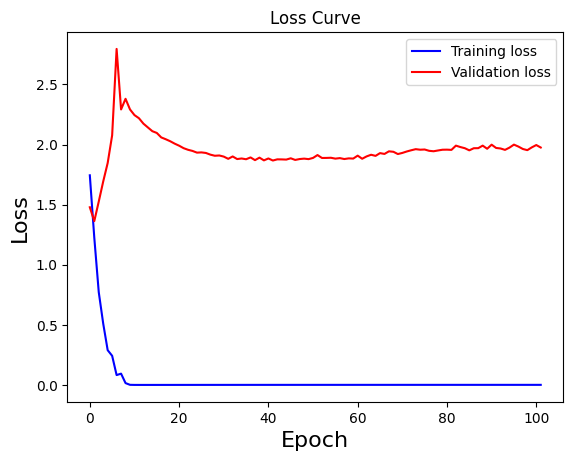

In [150]:
import matplotlib.pyplot as plt

plt.title('Loss Curve')
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.plot(train_losses[:],'b')
plt.plot(valid_losses[:],'r')
plt.legend(['Training loss','Validation loss'])
plt.show()

In [151]:
load_checkpoint(optimizer, model, pkl_name)

# reinitialize validation function with model from chosen checkpoint
validate = make_validate_fnc(model, criterion)

# Convert 4D test feature set array to tensor and move to GPU
X_test_tensor = torch.tensor(X_test, device=device).float()

# Convert 4D test label set array to tensor and move to GPU
y_test_tensor = torch.tensor(y_test, dtype=torch.long, device=device)

# Get the model's performance metrics using the validation function we defined
test_loss, test_acc, predicted_emotions = validate(X_test_tensor, y_test_tensor)
print(f'[*] Test accuracy is {test_acc:.2f}%')

[*] Test accuracy is 55.56%


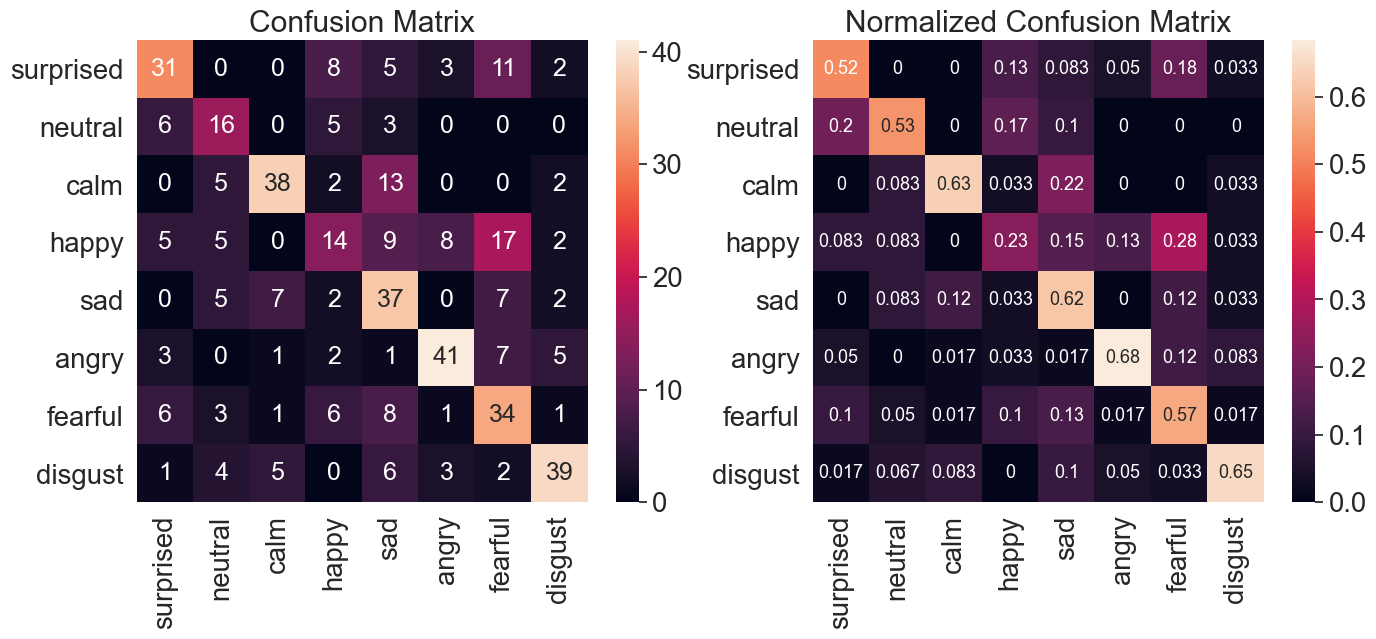

In [152]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

# because model tested on GPU, move prediction tensor to CPU then convert to array
predicted_emotions = predicted_emotions.cpu().numpy()
# use labels from test set
emotions_groundtruth = y_test

# build confusion matrix and normalized confusion matrix
conf_matrix = confusion_matrix(emotions_groundtruth, predicted_emotions)
conf_matrix_norm = confusion_matrix(emotions_groundtruth, predicted_emotions,normalize='true')

# set labels for matrix axes from emotions
emotion_names = [emotion for emotion in emotions_dict.values()]

# make a confusion matrix with labels using a DataFrame
confmatrix_df = pd.DataFrame(conf_matrix, index=emotion_names, columns=emotion_names)
confmatrix_df_norm = pd.DataFrame(conf_matrix_norm, index=emotion_names, columns=emotion_names)

# plot confusion matrices
plt.figure(figsize=(16,6))
sn.set(font_scale=1.8) # emotion label and title size
plt.subplot(1,2,1)
plt.title('Confusion Matrix')
sn.heatmap(confmatrix_df, annot=True, annot_kws={"size": 18}) #annot_kws is value font
plt.subplot(1,2,2)
plt.title('Normalized Confusion Matrix')
sn.heatmap(confmatrix_df_norm, annot=True, annot_kws={"size": 13}) #annot_kws is value font

plt.show()